# Reservoir calibration with SCE-UA
***

**Autor:** Chus Casado<br>
**Date:** 18-06-2024<br>

**To do:**<br>

**Questions:**<br>

In [1]:
import sys
sys.path.append('../../src/')
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from datetime import datetime, timedelta
import spotpy
# from spotpy.objectivefunctions import kge
import yaml
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
from lisfloodreservoirs.calibration import get_calibrator
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.utils.metrics import KGEmod

## Configuration

In [3]:
with open('config_linear_storage.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### Paths

PATH_DATASET = Path(cfg['paths']['dataset'])

### Reservoir model

MODEL = cfg['model'].lower()

### Calibration

# # sequential mode
# parallel = "seq"  

# calibration parameters
ALGORITHM = cfg['calibration']['algorithm'].lower()
TARGET = cfg['calibration']['target']
MAX_ITER = cfg['calibration'].get('max_iter', 1000)
COMPLEXES = cfg['calibration'].get('COMPLEXES', 4)
TRAIN_SIZE = cfg['calibration'].get('TRAIN_SIZE', 0.7)

# results will be saved in this path
PATH_OUT = Path('./') / MODEL / 'calibration' / ALGORITHM
if len(TARGET) == 1:
    PATH_OUT = PATH_OUT / 'univariate' / TARGET[0]
elif len(TARGET) == 2:
    PATH_OUT /= 'bivariate'
else:
    print('ERROR. Only univariate or bivariate calibrations are supported')
    sys.exit()
PATH_OUT.mkdir(parents=True, exist_ok=True)
print(f'Results will be saved in {PATH_OUT}')

Results will be saved in linear\calibration\sceua\univariate\storage


## Data

### GloFAS

#### Reservoirs

In [4]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../../GIS/reservoirs_analysis_US.shp')
reservoirs.set_index('ResID', drop=True, inplace=True)

print(f'{reservoirs.shape[0]} reservoirs in the shape file')

94 reservoirs in the shape file


#### Time series

In [5]:
# read GloFAS time series
path = Path('../../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(list(path.glob('*.csv')), desc='GloFAS time series'):
    ResID = int(file.stem)
    if ResID not in reservoirs.index:
        continue
    glofas_ts[ResID] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs in the GloFAS time series')

# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

# period of GloFAS simulation
start, end = glofas_ts[id].first_valid_index(), glofas_ts[id].last_valid_index()

GloFAS time series:   0%|          | 0/143 [00:00<?, ?it/s]

94 reservoirs in the GloFAS time series


### ResOpsUS
#### Time series

In [6]:
path_ResOps = PATH_DATASET / 'ResOpsUS'
resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

print(f'{len(resops_ts)} reservoirs in the ResOpsUS time series')
    
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

  0%|          | 0/94 [00:00<?, ?it/s]

94 reservoirs in the ResOpsUS time series


## Calibration

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  1000  repetitions
The objective function will be minimized
Starting burn-in sampling...


  0%|          | 0/9714 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'linear\calibration\sceua\univariate\storage/146_samples.csv' created.


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

5 of 1000, minimal objective function=0.407289, time remaining: 00:06:48


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

10 of 1000, minimal objective function=0.407289, time remaining: 00:07:29


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

19 of 1000, minimal objective function=0.407289, time remaining: 00:07:42


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

27 of 1000, minimal objective function=0.375947, time remaining: 00:07:03


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

35 of 1000, minimal objective function=0.372749, time remaining: 00:06:36


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

42 of 1000, minimal objective function=0.372749, time remaining: 00:06:15
ComplexEvo loop #2 in progress...


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

50 of 1000, minimal objective function=0.372749, time remaining: 00:06:08


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

58 of 1000, minimal objective function=0.372749, time remaining: 00:05:57


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

65 of 1000, minimal objective function=0.372749, time remaining: 00:05:47


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

72 of 1000, minimal objective function=0.372749, time remaining: 00:05:37
ComplexEvo loop #3 in progress...


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

81 of 1000, minimal objective function=0.372749, time remaining: 00:05:30


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

89 of 1000, minimal objective function=0.372749, time remaining: 00:05:22


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

98 of 1000, minimal objective function=0.372749, time remaining: 00:05:16


  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

  0%|          | 0/9714 [00:00<?, ?it/s]

107 of 1000, minimal objective function=0.372749, time remaining: 00:05:11
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.000000
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.010000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 109
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.563286
THE BEST POINT HAS IMPROVED IN LAST 3 LOOPS BY 0.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 37.61 seconds
Total Repetitions: 109
Minimal objective value: 0.372749
Corresponding parameter setting:
T: 360.853
******************************



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/4165 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

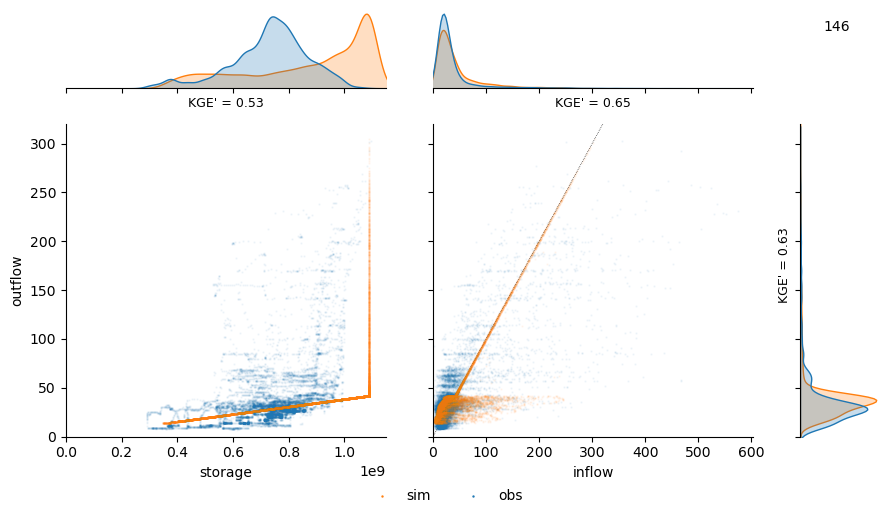

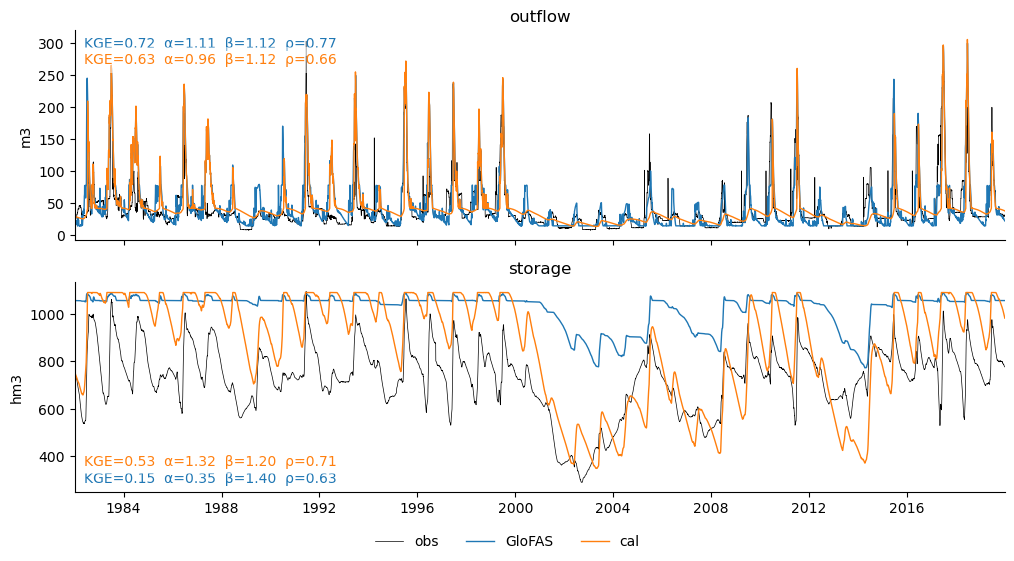

In [7]:
for ResID in tqdm([146]):#reservoirs.index):
    
    # file where the calibration results will be saved
    dbname = f'{PATH_OUT}/{ResID:03}_samples'
    if os.path.isfile(dbname + '.csv'):
        print(f'The file {dbname}.csv already exists.')
        continue   

    ## TIME SERIES
    try:
        # observed time series
        obs = resops_ts[ResID][['storage', 'inflow', 'outflow']].copy()
        obs[obs < 0] = np.nan

        # define calibration period
        if obs.outflow.isnull().all():
            print(f'Reservoir {ResID} is missing outflow records')
            continue
        elif obs.storage.isnull().all():
            print(f'Reservoir {ResID} is missing storage records')
            continue
        else:
            start_obs = max([obs[var].first_valid_index() for var in ['storage', 'outflow']])
            end_obs = min([obs[var].last_valid_index() for var in ['storage', 'outflow']])
            cal_days = timedelta(days=np.floor((end_obs - start_obs).days * TRAIN_SIZE))
            start_cal = end_obs - cal_days

        # define train and test time series
        x_train = glofas_ts[ResID].inflow[start_cal:end_obs]
        y_train = obs.loc[start_cal:end_obs, ['storage', 'outflow']]
        x_test = glofas_ts[ResID].inflow[start:start_cal]
        y_test = obs.loc[start_obs:start_cal, ['storage', 'outflow']]
        
    except Exception as e:
        print(f'ERROR. The time series of reservoir {ResID} could not be set up\n', e)
        continue

    ## SET UP SPOTPY
    try:
        # extract GloFAS reservoir parameters
        Vmin, Vtot, Qmin = reservoirs.loc[ResID, ['clim', 'CAP', 'minq']]
        Vtot *= 1e6
        Vmin *= Vtot

        # initialize the calibration setup of the LISFLOOD reservoir routine
        setup = get_calibrator(MODEL,
                               inflow=x_train,
                               storage=y_train.storage, 
                               outflow=y_train.outflow,
                               Vmin=Vmin,
                               Vtot=Vtot,
                               Qmin=Qmin,
                               target=TARGET,
                               obj_func=KGEmod)

        # define the sampling method
        sceua = spotpy.algorithms.sceua(setup, dbname=dbname, dbformat='csv', save_sim=False)
    except Exception as e:
        print(f'ERROR. The SpotPY set up of reservoir {ResID} could not be done\n', e)
        continue
        
    ## LAUNCH SAMPLING
    try:
        # start the sampler
        sceua.sample(MAX_ITER, ngs=COMPLEXES, kstop=3, pcento=0.01, peps=0.1)
    except Exception as e:
        print(f'ERROR. While sampling the reservoir {ResID}\n', e)
        continue

    ### VALIDATION
    # read CSV of results
    try:
        results = pd.read_csv(f'{dbname}.csv')
        results.index.name = 'iteration'
        parcols = [col for col in results.columns if col.startswith('par')]
    except Exception as e:
        print(f'ERROR while reading results form reservoir {ResID}\n', e)
        continue
    
    # compute validation KGE of each simulation and overwrite CSV file
    try:       
        results['like_val'] = np.nan
        for i in tqdm(results.index):
            sim = setup.simulation(pars=results.loc[i, parcols],
                                   inflow=x_test,
                                   storage_init=y_test.storage[0])
            results.loc[i, 'like_val'] = np.sqrt(np.sum([(1 - KGEmod(y_test[var], sim[var])[0])**2 for var in TARGET]))
        results.to_csv(f'{dbname}.csv', index=False, float_format='%.8f')
    except Exception as e:
        print(f'ERROR while computing KGE for the validation period in reservoir {ResID}\n', e)
    
    # select optimal parameters (best validation) and export them
    try:
        best_iter = results.like_val.idxmin() # results.like1.idxmin()
        parvalues = {col[3:]: float(results.loc[best_iter, col]) for col in parcols}
        with open(f'{PATH_OUT}/{ResID:03}_optimal_parameters.yml', 'w') as file:
            yaml.dump(parvalues, file)
    except Exception as e:
        print(f'ERROR while searching for optimal parameters in reservoir {ResID}\n', e)
        continue
    
    # simulate the whole observed period with the optimal parameterization
    try:       
        if MODEL.lower() == 'linear':
            args = [Vmin, Vtot, Qmin, parvalues['T']]
        elif MODEL.lower() == 'lisflood':
            Vf = parvalues['FFf'] * Vtot
            Vn = Vc + parvalues['alpha'] * (Vf - Vc)
            Vn_adj = Vn + parvalues['beta'] * (Vf - Vn)
            Qf = setup.inflow.quantile(parvalues['QQf'])
            Qn = parvalues['gamma'] * Qf
            k = parvalues['k']
            args = [Vmin, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qf]
        else:
            raise ValueError(f'Model {MODEL} is not supported')
        res = get_model(MODEL, *args)  
        sim = res.simulate(glofas_ts[ResID].inflow[start_obs:end_obs],
                           obs.storage[start_obs])
        
        # performance
        performance = pd.DataFrame(index=['KGE', 'alpha', 'beta', 'rho'], columns=obs.columns)
        for var in performance.columns:
            try:
                performance[var] = KGEmod(obs[var], sim[var])
            except:
                continue
        file_out = PATH_OUT / f'{ResID:03}_performance.csv'
        performance.to_csv(file_out, float_format='%.3f')
        
        res.scatter(sim,
                    obs,
                    norm=False,
                    title=ResID,
                    save=PATH_OUT / f'{ResID:03}_scatter.jpg'
                   )
        
        res.lineplot({'GloFAS': glofas_ts[ResID], 'cal': sim},
                     obs,
                     save=PATH_OUT / f'{ResID:03}_lineplot.jpg'
                    )
    except Exception as e:
        print(f'ERROR while simulating with optimal parameters in reservoir {ResID}\n', e)